In [ ]:
!pip install hub urllib3==1.26.7 torchmetrics iterative-stratification timm pytorch-lightning --quiet
!wget https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf

     |████████████████████████████████| 138 kB 14.1 MB/s 
     |████████████████████████████████| 419 kB 56.8 MB/s 
     |████████████████████████████████| 548 kB 66.4 MB/s 
     |████████████████████████████████| 708 kB 69.9 MB/s 
     |████████████████████████████████| 437 kB 88.5 MB/s 
     |████████████████████████████████| 163 kB 72.2 MB/s 
     |████████████████████████████████| 5.9 MB 42.9 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 132 kB 62.4 MB/s 
     |████████████████████████████████| 6.6 MB 23.5 MB/s 
     |████████████████████████████████| 10.5 MB 23.2 MB/s 
     |████████████████████████████████| 76 kB 5.3 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 9.2 MB 41.4 MB/s 
     |████████████████████████████████| 52 kB 1.0 MB/s 
     |████████████████████████████████| 115 kB 65.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the p

In [ ]:
import json
import pickle
import warnings
from copy import copy, deepcopy
from getpass import getpass
from pathlib import Path
from typing import Any, Callable, Dict, List, Tuple

import random
import cv2
import hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import timm  # https://rwightman.github.io/pytorch-image-models/
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torchvision
import seaborn as sns
from iterstrat.ml_stratifiers import (MultilabelStratifiedKFold,
                                      MultilabelStratifiedShuffleSplit)
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from pytorch_lightning import Callback, Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class_names = ["Background", "Crack", "Spallation", "Efflorescence", "ExposedBars", "CorrosionStain"]

# Ignore background class for classification task
class_names_classification = ["Crack", "Spallation", "Efflorescence", "ExposedBars", "CorrosionStain"]

In [ ]:
class args:
    models_dir = Path("/content/drive/MyDrive/Trabalho/Fruitpunch/AI for damage inspection/models/vit_small_patch32_384/")

In [ ]:
def predict(model, loaders: List, loaders_names: List[str]) -> Dict:
    """Generate predictions with a model for each loader in loaders list."""
    outputs = {}
    threshold = 0.5
    for loader, partition in zip(loaders, loaders_names):
        partition_outputs = {}
        predictions = []
        targets = []
        for batch in tqdm(loader):
            with torch.no_grad():
                img, target = batch
                output = model(img.to(model.device))

                preds = model.sigmoid(output).cpu().clone().detach()
                target = target.cpu().clone().detach().to(torch.int32)
                predictions.append(preds)
                targets.append(target)

        partition_outputs["predictions"] = torch.cat(predictions)
        partition_outputs["targets"] = torch.cat(targets)
        outputs[partition] = partition_outputs
    return outputs

def _compute_scores(prediction_outputs: Dict[str, torch.Tensor]) -> Tuple:
    """Compute F1 and Accuracy for a partition's prediction outputs."""
    preds = (prediction_outputs["predictions"] >= 0.5).numpy().astype(int)
    targets = prediction_outputs["targets"]

    accuracy = accuracy_score(targets, preds)
    f1_avg = f1_score(targets, preds, average="macro")
    f1_per_class = f1_score(targets, preds, average=None)

    recall_per_class = recall_score(targets, preds, average=None)
    precision_per_class = precision_score(targets, preds, average=None)

    return accuracy, f1_avg, f1_per_class, recall_per_class, precision_per_class

def compute_scores(run_outputs: Dict, train_size: int) -> pd.DataFrame:
    """Compute F1 and Accuracy for a run's predictions output.
    
    A run's output is composed of all desired partitions (train, val, test).

    """
    metrics = pd.DataFrame()
    for partition, data in run_outputs.items():
        accuracy, f1_avg, f1_per_class, recall_per_class, precision_per_class = _compute_scores(data)
        
        metrics = pd.concat([metrics, pd.DataFrame({
            "partition": partition,
            "train_size": train_size,
            "accuracy": accuracy,
            "f1_avg": f1_avg,
            "f1_per_class": ", ".join([str(round(f, 4)) for f in f1_per_class]),
            "recall_per_class": ", ".join([str(round(f, 4)) for f in recall_per_class]),
            "precision_per_class": ", ".join([str(round(f, 4)) for f in precision_per_class]),
        }, index=[0])])
    return metrics

In [ ]:
def get_checkpoint(train_size: int, mode="best"):
    drive_save_folder = args.models_dir / f"train_size_{train_size}"
    if mode == "best":
        ckpt_path = list(drive_save_folder.glob("checkpoints/epoch*"))[0]
    elif mode == "last":
        ckpt_path = drive_save_folder / "checkpoints/last.ckpt"
    return ckpt_path

paths = {}
for run_folder in sorted(list(args.models_dir.glob("train_size*"))):
    
    train_size = str(run_folder).split("_")[-1]
    paths[int(train_size)] = get_checkpoint(train_size, mode="best")

paths

{100: PosixPath('/content/drive/MyDrive/Trabalho/Fruitpunch/AI for damage inspection/models/vit_small_patch32_384/train_size_100/checkpoints/epoch=14-valid_loss=0.5060-valid_f1=0.7290.ckpt'),
 200: PosixPath('/content/drive/MyDrive/Trabalho/Fruitpunch/AI for damage inspection/models/vit_small_patch32_384/train_size_200/checkpoints/epoch=12-valid_loss=0.4380-valid_f1=0.8036.ckpt'),
 300: PosixPath('/content/drive/MyDrive/Trabalho/Fruitpunch/AI for damage inspection/models/vit_small_patch32_384/train_size_300/checkpoints/epoch=12-valid_loss=0.5304-valid_f1=0.7931.ckpt'),
 400: PosixPath('/content/drive/MyDrive/Trabalho/Fruitpunch/AI for damage inspection/models/vit_small_patch32_384/train_size_400/checkpoints/epoch=13-valid_loss=0.5045-valid_f1=0.7938.ckpt'),
 900: PosixPath('/content/drive/MyDrive/Trabalho/Fruitpunch/AI for damage inspection/models/vit_small_patch32_384/train_size_900/checkpoints/epoch=09-valid_loss=0.3617-valid_f1=0.8474.ckpt')}

In [ ]:
scores = pd.DataFrame()
filename = "prediction_outputs.pkl"
for train_size, curr_path in paths.items():
    predictions_path = curr_path.parents[1] / filename
    if predictions_path.exists():
        with open(predictions_path, "rb") as f:
            run_outputs = pickle.load(f)
        run_scores = compute_scores(run_outputs, train_size)
        scores = pd.concat([scores, run_scores])
    else:
        warnings.warn(f"{predictions_path} does not exist.")
scores = scores.reset_index(drop=True)

scores["class_name"] = ", ".join(class_names_classification)
scores["class_name"] = scores["class_name"].apply(lambda x: x.split(", "))
scores["f1_per_class"] = scores["f1_per_class"].apply(lambda x: x.split(", "))
scores["recall_per_class"] = scores["recall_per_class"].apply(lambda x: x.split(", "))
scores["precision_per_class"] = scores["precision_per_class"].apply(lambda x: x.split(", "))

In [ ]:
scores.head(5)

,partition,train_size,accuracy,f1_avg,f1_per_class,recall_per_class,precision_per_class,class_name
0,train,100,0.974359,0.993446,"[1.0, 0.9885, 0.9787, 1.0, 1.0]","[1.0, 1.0, 0.9583, 1.0, 1.0]","[1.0, 0.9773, 1.0, 1.0, 1.0]","[Crack, Spallation, Efflorescence, ExposedBars..."
1,val,100,0.230769,0.693274,"[0.6923, 0.7407, 0.3636, 0.8235, 0.8462]","[0.75, 0.9091, 0.3333, 0.875, 1.0]","[0.6429, 0.625, 0.4, 0.7778, 0.7333]","[Crack, Spallation, Efflorescence, ExposedBars..."
2,test,100,0.282895,0.703670,"[0.7725, 0.7541, 0.4444, 0.8244, 0.7229]","[0.8022, 0.8519, 0.3478, 0.8438, 0.7229]","[0.7449, 0.6765, 0.6154, 0.806, 0.7229]","[Crack, Spallation, Efflorescence, ExposedBars..."
3,train,200,0.943750,0.989258,"[0.9796, 0.9884, 0.9897, 1.0, 0.9886]","[1.0, 0.9884, 0.9796, 1.0, 1.0]","[0.96, 0.9884, 1.0, 1.0, 0.9775]","[Crack, Spallation, Efflorescence, ExposedBars..."
4,val,200,0.475000,0.786884,"[0.8511, 0.8, 0.6154, 0.8235, 0.8444]","[0.8333, 0.7619, 0.6667, 0.8235, 0.8636]","[0.8696, 0.8421, 0.5714, 0.8235, 0.8261]","[Crack, Spallation, Efflorescence, ExposedBars..."


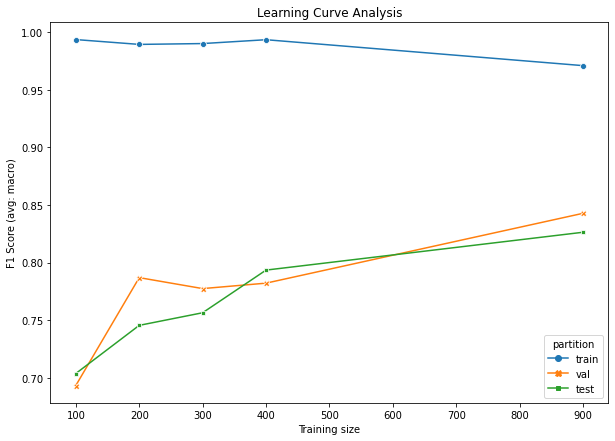

In [ ]:
plt.figure(figsize=(10, 7))
sns.lineplot(
    data=scores,
    x="train_size",
    y="f1_avg",
    hue="partition",
    style="partition",
    markers=True, 
    dashes=False
)
plt.title("Learning Curve Analysis")
plt.xlabel("Training size")
plt.ylabel("F1 Score (avg: macro)")
plt.savefig("lca_f1_macro.png")
plt.show()

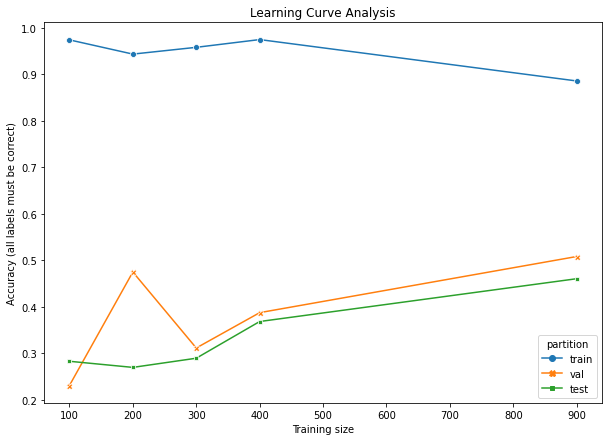

In [ ]:
plt.figure(figsize=(10, 7))

sns.lineplot(
    data=scores,
    x="train_size",
    y="accuracy", # all labels correct = 1, any label incorrect = 0
    hue="partition",
    style="partition",
    markers=True, 
    dashes=False
)
plt.title("Learning Curve Analysis")
plt.xlabel("Training size")
plt.ylabel("Accuracy (all labels must be correct)")
plt.savefig("lca_accuracy.png")
plt.show()

In [ ]:
classes = scores[["partition", "train_size", "class_name"]].explode(column="class_name")
f1_per_class = scores[["f1_per_class"]].explode(column="f1_per_class")
recall_per_class = scores[["recall_per_class"]].explode(column="recall_per_class")
precision_per_class = scores[["precision_per_class"]].explode(column="precision_per_class")
scores_per_class = pd.concat([classes, f1_per_class, recall_per_class, precision_per_class], axis=1)
scores_per_class[["f1_per_class", "recall_per_class", "precision_per_class"]] = scores_per_class[["f1_per_class", "recall_per_class", "precision_per_class"]].astype(float)

In [ ]:
scores_per_class.head(5)

,partition,train_size,class_name,f1_per_class,recall_per_class,precision_per_class
0,train,100,Crack,1.0000,1.0000,1.0000
0,train,100,Spallation,0.9885,1.0000,0.9773
0,train,100,Efflorescence,0.9787,0.9583,1.0000
0,train,100,ExposedBars,1.0000,1.0000,1.0000
0,train,100,CorrosionStain,1.0000,1.0000,1.0000


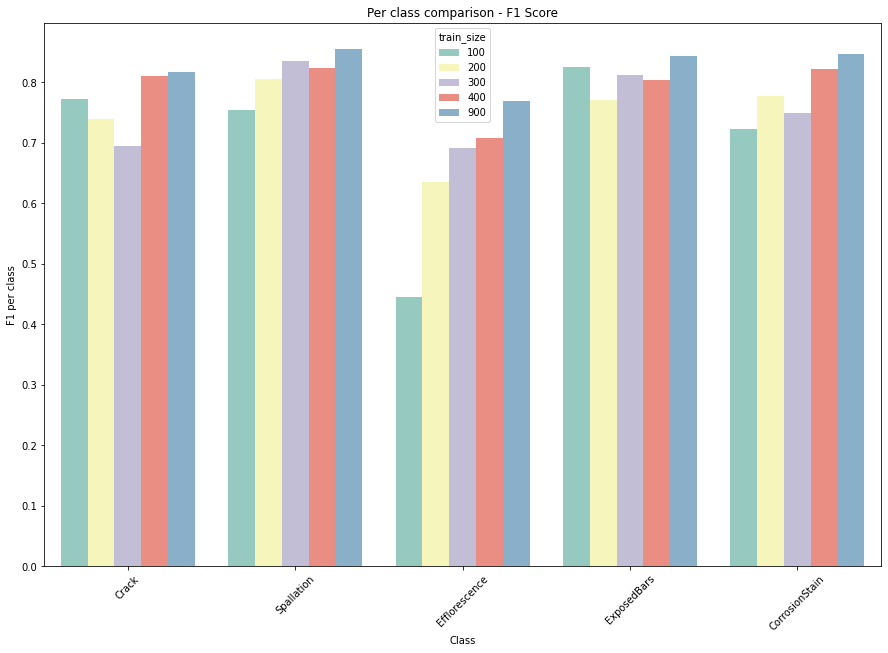

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(
    data=scores_per_class.query("partition == 'test'"),
    x="class_name",
    hue="train_size",
    y="f1_per_class",
    palette="Set3"
)
plt.xticks(rotation=45)
plt.title("Per class comparison - F1 Score")
plt.xlabel("Class")
plt.ylabel("F1 per class")
plt.savefig("f1_per_class.png")
plt.show()

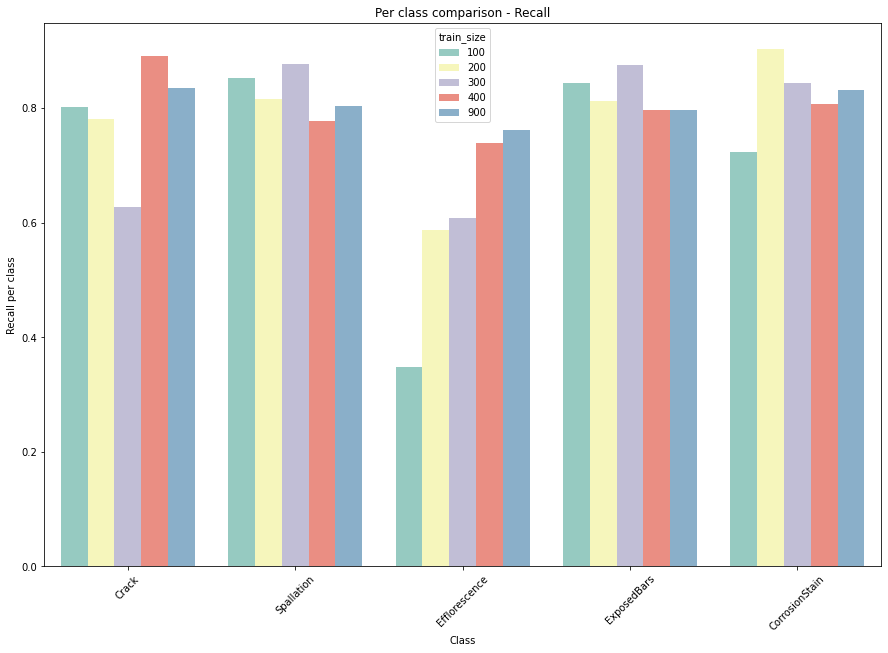

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(
    data=scores_per_class.query("partition == 'test'"),
    x="class_name",
    hue="train_size",
    y="recall_per_class",
    palette="Set3"
)
plt.title("Per class comparison - Recall")
plt.xlabel("Class")
plt.ylabel("Recall per class")
plt.savefig("recall_per_class.png")
plt.xticks(rotation=45)
plt.show()

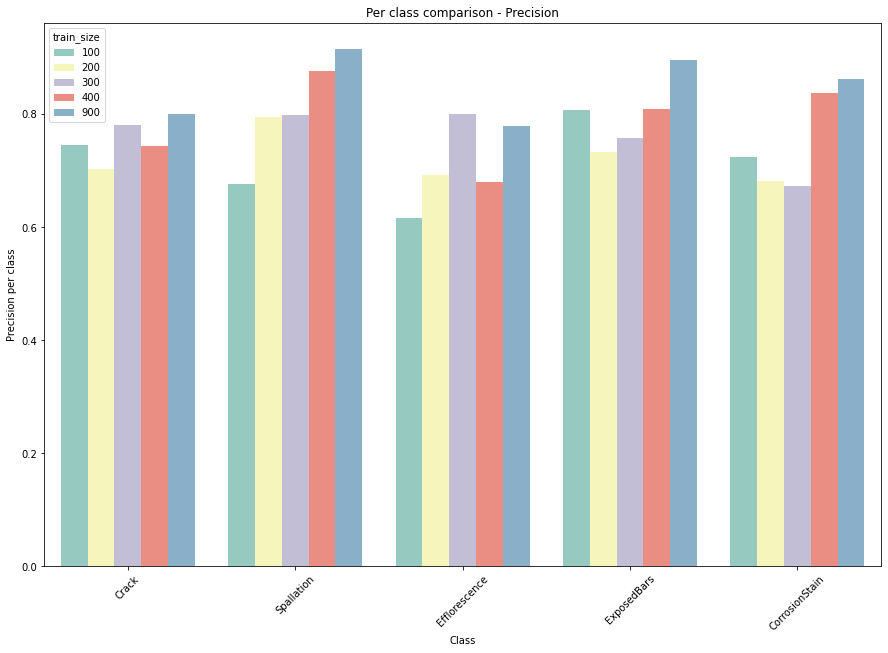

In [ ]:
plt.figure(figsize=(15, 10))
sns.barplot(
    data=scores_per_class.query("partition == 'test'"),
    x="class_name",
    hue="train_size",
    y="precision_per_class",
    palette="Set3"
)
plt.title("Per class comparison - Precision")
plt.xlabel("Class")
plt.ylabel("Precision per class")
plt.savefig("precision_per_class.png")
plt.xticks(rotation=45)
plt.show()